Fetch Dataset

In [ ]:
import os
import zipfile
import requests

# Define the GitHub raw file URL
zip_url = "https://github.com/Lama-Aldhafeeri/TaSch/raw/main/task_machine_datasets_2000_tasks_variable.zip"

# Download the zip file
zip_path = "task_machine_datasets_2000.zip"
response = requests.get(zip_url)
with open(zip_path, "wb") as file:
    file.write(response.content)

# Extract the zip file
dataset_path = "dataset"
os.makedirs(dataset_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(dataset_path)

# Verify extraction
dataset_files = sorted(os.listdir(dataset_path))
print(f"Extracted {len(dataset_files)} dataset files!")
print(f"Example file: {dataset_files[:5]}")

Extracted 2000 dataset files!
Example file: ['instance_10_100_10_1.txt', 'instance_10_100_10_10.txt', 'instance_10_100_10_11.txt', 'instance_10_100_10_12.txt', 'instance_10_100_10_13.txt']


Load Dataset Files

In [ ]:
import os
import numpy as np
import pandas as pd

def read_data(file_path):
    """Reads benchmark data from a given file."""
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Parse tasks
    tasks = list(map(int, lines[0].strip().split()))

    # Parse virtual machines
    vms = list(map(int, lines[1].strip().split()))

    # Parse execution times
    times = {}
    for entry in lines[2:]:
        task, vm, time = map(int, entry.strip().strip("()").split(","))
        times[(task, vm)] = time
    return tasks, vms, times


# Verify dataset loading
print(f"Loaded {len(dataset_files)} dataset files!")
print(f"Example file: {dataset_files[0]}")

Loaded 2000 dataset files!
Example file: instance_10_100_10_1.txt


Setup compute imbalance factor

In [ ]:
def compute_degree_of_imbalance(vm_loads):
    """Compute Degree of Imbalance (DI) as per Eq. (8)."""
    T_max = np.max(vm_loads)  # Maximum execution time among VMs
    T_min = np.min(vm_loads)  # Minimum execution time among VMs
    T_avg = np.mean(vm_loads)  # Average execution time among VMs

    if T_avg == 0:
        return 0  # Avoid division by zero

    DI = (T_max + T_min) / T_avg
    return DI

Define the ACO

In [ ]:
import numpy as np

class AntColonyOptimization:
    def __init__(self, num_ants, num_iterations, alpha, beta, rho, Q):
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.alpha = alpha
        self.beta = beta
        self.rho = rho  # Evaporation rate
        self.Q = Q  # Pheromone deposit factor

    def run(self, distance_matrix):
        """Run the ACO algorithm for a given distance matrix (task-VM execution times)."""
        num_tasks, num_vms = distance_matrix.shape

        # Compute heuristic values (η_ij = 1 / d_ij), avoiding division by zero
        heuristic_matrix = np.where(distance_matrix > 0, 1 / distance_matrix, 1e-10)

        # Initialize pheromone matrix (τ_ij = 1)
        pheromone_matrix = np.ones((num_tasks, num_vms))

        # Track best solution
        best_solution = None
        best_makespan = float('inf')
        best_vm_loads = None  # Store best VM loads

        # ACO Algorithm
        for iteration in range(self.num_iterations):
            all_solutions = []
            all_makespans = []
            all_vm_loads = []

            for ant in range(self.num_ants):
                solution = []
                vm_loads = np.zeros(num_vms)  # Initialize VM loads

                for task in range(num_tasks):
                    # Compute probabilities for each VM
                    probabilities = (pheromone_matrix[task] ** self.alpha) * (heuristic_matrix[task] ** self.beta)

                    # Add a small value to avoid zero division
                    prob_sum = probabilities.sum()
                    if prob_sum == 0:
                      probabilities = np.ones(num_vms) / num_vms  # Reset to equal probability
                    else:
                      probabilities /= prob_sum

                    # Select VM based on probability
                    vm_choice = np.random.choice(num_vms, p=probabilities)
                    solution.append((task, vm_choice))
                    vm_loads[vm_choice] += distance_matrix[task, vm_choice]  # Update VM load

                # Compute makespan
                makespan = max(vm_loads)
                all_solutions.append(solution)
                all_makespans.append(makespan)
                all_vm_loads.append(vm_loads.copy())

            # Select best solution from this iteration
            min_index = np.argmin(all_makespans)
            if all_makespans[min_index] < best_makespan:
                best_makespan = all_makespans[min_index]
                best_solution = all_solutions[min_index]
                best_vm_loads = all_vm_loads[min_index]

            # Pheromone update
            pheromone_matrix *= (1 - self.rho)  # Evaporation
            for task, vm in best_solution:
                pheromone_matrix[task, vm] += self.Q / best_makespan

        return best_solution, best_makespan, best_vm_loads, all_makespans

Apply ACO on a Small Example

In [ ]:
# Apply ACO on a Small Example

# Define a small 5-task, 3-VM problem
small_distance_matrix = np.array([
    [7, 8, 5],
    [6, 7, 9],
    [8, 5, 6],
    [9, 6, 7],
    [5, 9, 8]
])

# Initialize and Run ACO
aco = AntColonyOptimization(num_ants=5, num_iterations=50, alpha=1, beta=2, rho=0.1, Q=100)
best_solution, best_makespan, _ , _ = aco.run(small_distance_matrix)

# Print results for the small example
print("\n Small Example:")
print(f"Best Solution: {best_solution}")
print(f"Best Makespan: {best_makespan}")


 Small Example:
Best Solution: [(0, 2), (1, 0), (2, 1), (3, 1), (4, 0)]
Best Makespan: 11.0


Test ACO On Generated Dataset

In [ ]:
# Initialize ACO
aco = AntColonyOptimization(num_ants=10, num_iterations=100, alpha=0.3, beta=1, rho=0.5, Q=100)

# Store Results for Plotting
results = {
    "dataset": [],
    "num_tasks": [],
    "best_makespan": [],
    "worst_makespan": [],
    "avg_makespan": [],
    "degree_of_imbalance": []
}

# Dataset path (change this to your directory)
dataset_path = "dataset"
dataset_files = os.listdir(dataset_path)

# Apply ACO to All Datasets and Collect Data
for dataset_file in dataset_files:
    file_path = os.path.join(dataset_path, dataset_file)
    tasks, vms, times = read_data(file_path)

    # Extract task and VM counts
    num_tasks = len(tasks)
    num_vms = len(vms)


    # Create distance matrix
    distance_matrix = np.zeros((num_tasks, num_vms))
    for (task, vm), time in times.items():
        distance_matrix[task - 1, vm - 1] = time  # Adjust index for 0-based array
    # print(f"\nDistance Matrix for {dataset_file}:\n", distance_matrix)

    # Run ACO
    aco.num_tasks = num_tasks
    aco.num_vms = num_vms
    aco.distance_matrix = distance_matrix

    best_solution, best_makespan, best_vm_loads, all_makespans = aco.run(distance_matrix)

    # Compute Best, Worst, and Average Makespan
    worst_makespan = max(all_makespans)  # Worst makespan (highest)
    avg_makespan = np.mean(all_makespans)  # # Average best makespan per iteration

    # Compute Load Imbalance: Balance Factor = Max Load / Average Load
    avg_load = np.mean(best_vm_loads)
    max_load = np.max(best_vm_loads)

    # Compute Corrected Degree of Imbalance (DI)
    degree_of_imbalance = compute_degree_of_imbalance(best_vm_loads)
    print("\nBest VM Loads for", dataset_file, ":", best_vm_loads)
    print(f"Computed Best Makespan (max VM load): {max(best_vm_loads)}")
    print(f"Total Task Execution Time for {dataset_file}: {np.sum(distance_matrix)}")

    # Store Results
    results["dataset"].append(dataset_file)
    results["num_tasks"].append(num_tasks)
    results["best_makespan"].append(best_makespan)
    results["worst_makespan"].append(worst_makespan)
    results["avg_makespan"].append(avg_makespan)
    results["degree_of_imbalance"].append(degree_of_imbalance)

# Convert results to DataFrame
df_results = pd.DataFrame(results)
print(df_results)

Streaming output truncated to the last 5000 lines.
Total Task Execution Time for instance_7_100_10_20.txt: 7406.0

Best VM Loads for instance_7_50_10_8.txt : [37. 34. 30. 32. 34. 38. 26. 35. 38. 32.]
Computed Best Makespan (max VM load): 38.0
Total Task Execution Time for instance_7_50_10_8.txt: 3757.0

Best VM Loads for instance_10_70_10_12.txt : [51. 49. 49. 52. 32. 49. 52. 49. 43. 52.]
Computed Best Makespan (max VM load): 52.0
Total Task Execution Time for instance_10_70_10_12.txt: 5277.0

Best VM Loads for instance_2_90_10_4.txt : [65. 65. 62. 67. 63. 62. 65. 63. 60. 67.]
Computed Best Makespan (max VM load): 67.0
Total Task Execution Time for instance_2_90_10_4.txt: 6802.0

Best VM Loads for instance_2_90_10_19.txt : [70. 70. 68. 60. 50. 62. 57. 51. 65. 70.]
Computed Best Makespan (max VM load): 70.0
Total Task Execution Time for instance_2_90_10_19.txt: 6714.0

Best VM Loads for instance_3_80_10_7.txt : [61. 53. 42. 55. 59. 61. 50. 53. 54. 59.]
Computed Best Makespan (max VM loa

In [ ]:
# Find the Best Result from the Results List

# Find the dataset with the minimum (best) makespan
best_index = df_results["best_makespan"].idxmin()
best_result = df_results.loc[best_index]

# Print the best result
print("Best Result Found:")
print(best_result)

Best Result Found:
dataset                instance_6_10_10_14.txt
num_tasks                                   10
best_makespan                              7.0
worst_makespan                             7.0
avg_makespan                               7.0
degree_of_imbalance                   1.969697
Name: 1795, dtype: object


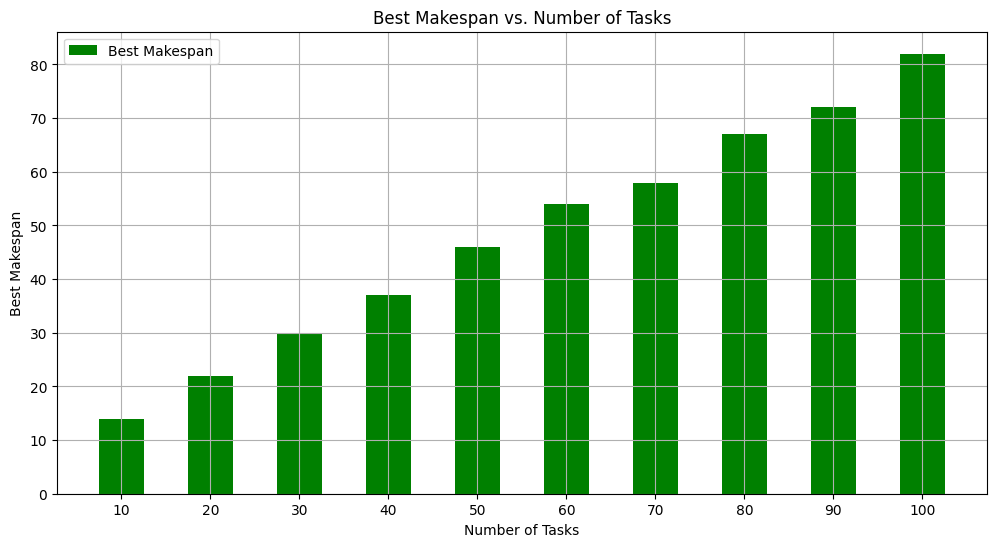

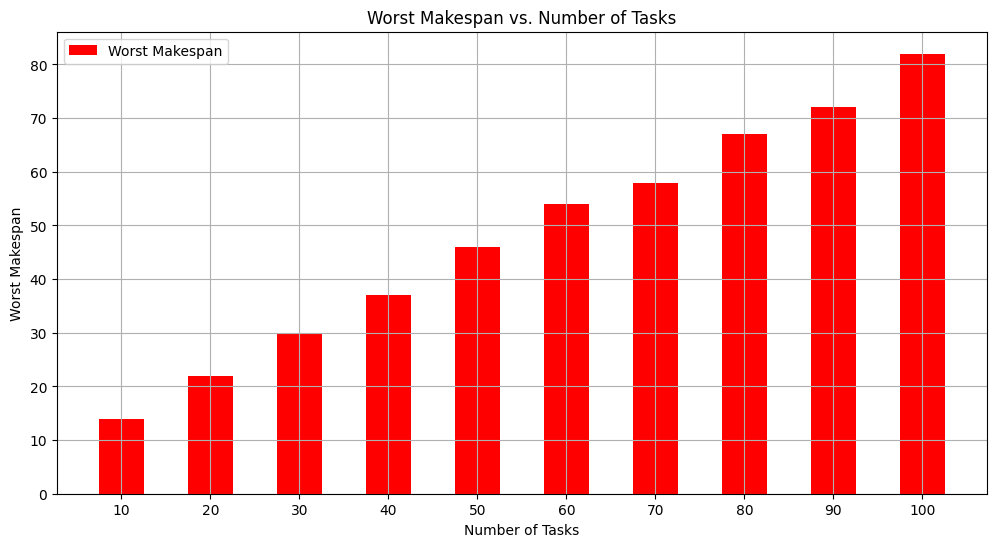

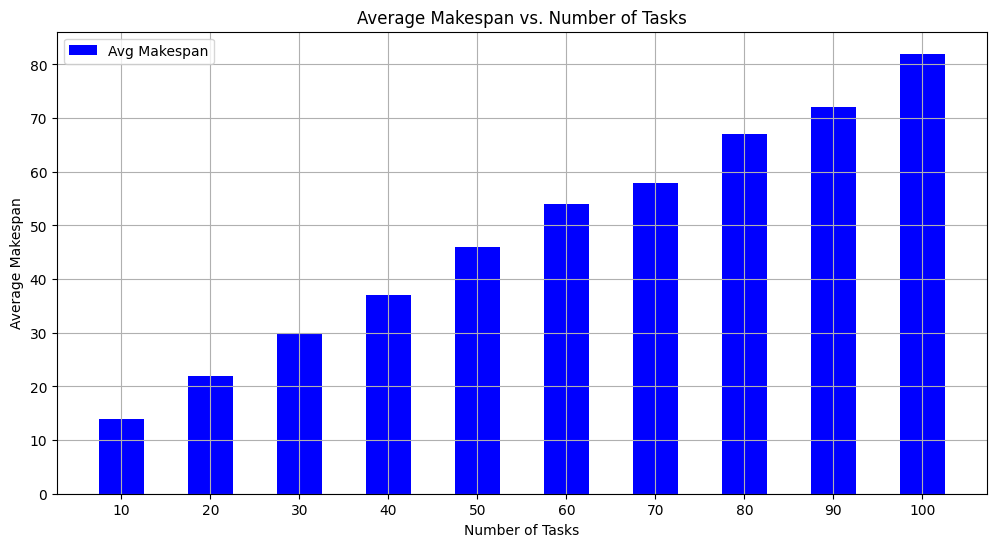

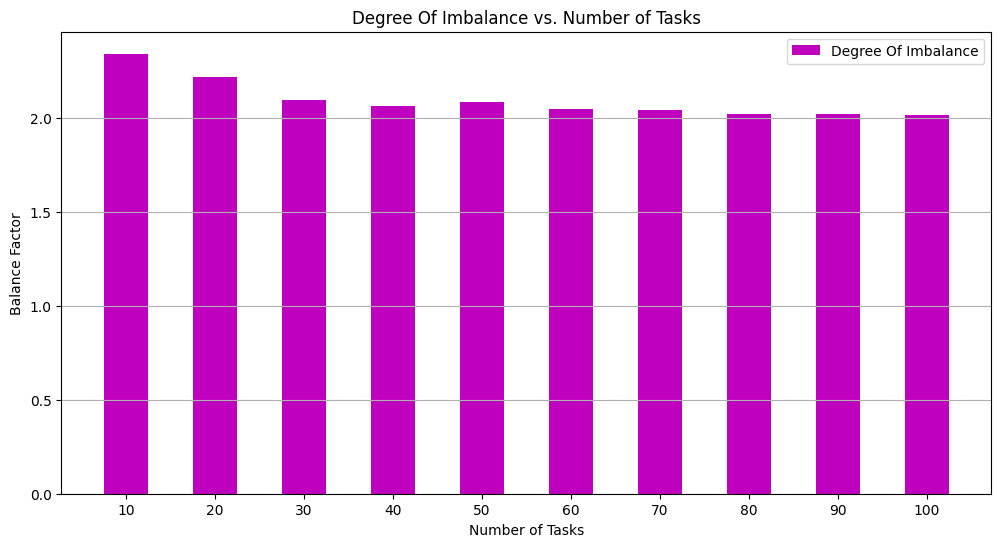

,dataset,num_tasks,best_makespan,worst_makespan,avg_makespan,degree_of_imbalance
0,instance_4_90_10_10.txt,90,66.0,66.0,66.0,1.800327
1,instance_2_90_10_14.txt,90,64.0,64.0,64.0,1.959459
2,instance_10_70_10_3.txt,70,49.0,49.0,49.0,1.995516
3,instance_2_50_10_2.txt,50,41.0,41.0,41.0,1.637427
4,instance_10_80_10_11.txt,80,60.0,60.0,60.0,1.883239
...,...,...,...,...,...,...
1995,instance_3_60_10_8.txt,60,46.0,46.0,46.0,1.704261
1996,instance_8_50_10_20.txt,50,39.0,39.0,39.0,1.834320
1997,instance_7_10_10_11.txt,10,10.0,10.0,10.0,1.333333
1998,instance_4_20_10_2.txt,20,18.0,18.0,18.0,1.796875


In [ ]:
import matplotlib.pyplot as plt

#  Plot Best Makespan vs. Number of Tasks
plt.figure(figsize=(12, 6))
plt.bar(df_results["num_tasks"], df_results["best_makespan"], color='g', label="Best Makespan", width=5)
plt.xlabel("Number of Tasks")
plt.ylabel("Best Makespan")
plt.title("Best Makespan vs. Number of Tasks")
plt.xticks(ticks=range(10, 110, 10))  # Ensure x-axis shows 10, 20, ..., 100
plt.legend()
plt.grid()
plt.show()

#  Plot Worst Makespan vs. Number of Tasks
plt.figure(figsize=(12, 6))
plt.bar(df_results["num_tasks"], df_results["worst_makespan"], color='r', label="Worst Makespan", width=5)
plt.xlabel("Number of Tasks")
plt.ylabel("Worst Makespan")
plt.title("Worst Makespan vs. Number of Tasks")
plt.xticks(ticks=range(10, 110, 10))
plt.legend()
plt.grid()
plt.show()

#  Plot Average Makespan vs. Number of Tasks
plt.figure(figsize=(12, 6))
plt.bar(df_results["num_tasks"], df_results["avg_makespan"],  color='b', label="Avg Makespan", width=5)
plt.xlabel("Number of Tasks")
plt.ylabel("Average Makespan")
plt.title("Average Makespan vs. Number of Tasks")
plt.xticks(ticks=range(10, 110, 10))
plt.legend()
plt.grid()
plt.show()

#  Plot Balance Factor vs. Number of Tasks
plt.figure(figsize=(12, 6))
plt.bar(df_results["num_tasks"], df_results["degree_of_imbalance"], color='m', label="Degree Of Imbalance", width=5)
plt.xlabel("Number of Tasks")
plt.ylabel("Balance Factor")
plt.title("Degree Of Imbalance vs. Number of Tasks")
plt.xticks(ticks=range(10, 110, 10))  # Ensure x-axis shows 10, 20, ..., 100
plt.legend()
plt.grid(axis='y')
plt.show()

#  Display updated results table
display(df_results)